In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Indian_Extent = pd.read_excel(filepath, sheet_name='Indian-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Indian_Extent)
fp.date_time(Indian_Extent)

,Extent,Date
0,376618.799,1979-01-01
1,211788.726,1979-02-01
2,262868.141,1979-03-01
3,698377.304,1979-04-01
4,1252407.727,1979-05-01
...,...,...
533,1520776.003,2023-06-01
534,2076164.165,2023-07-01
535,2731799.027,2023-08-01
536,3179384.692,2023-09-01


In [5]:
scaler = MinMaxScaler()
Indian_Extent['Extent'] = scaler.fit_transform(Indian_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 3
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Indian_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((524, 12, 1), (524,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Indian_model_LT3/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 9s 114ms/step - loss: 0.2422 - root_mean_squared_error: 0.4922 - val_loss: 0.1510 - val_root_mean_squared_error: 0.3886
Epoch 2/50
53/53 [==============================] - 6s 111ms/step - loss: 0.1256 - root_mean_squared_error: 0.3544 - val_loss: 0.0587 - val_root_mean_squared_error: 0.2424
Epoch 3/50
53/53 [==============================] - 5s 93ms/step - loss: 0.0583 - root_mean_squared_error: 0.2414 - val_loss: 0.0455 - val_root_mean_squared_error: 0.2134
Epoch 4/50
53/53 [==============================] - 7s 127ms/step - loss: 0.0412 - root_mean_squared_error: 0.2031 - val_loss: 0.0304 - val_root_mean_squared_error: 0.1744
Epoch 5/50
53/53 [==============================] - 7s 136ms/step - loss: 0.0269 - root_mean_squared_error: 0.1639 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1375
Epoch 6/50
53/53 [==============================] - 7s 138ms/step - loss: 0.0196 - root_mean_squared_error: 0.1401 - val_loss: 0.0138 - val_r

53/53 [==============================] - 7s 139ms/step - loss: 0.0082 - root_mean_squared_error: 0.0907 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0813
Epoch 31/50
53/53 [==============================] - 1s 22ms/step - loss: 0.0086 - root_mean_squared_error: 0.0926 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0855
Epoch 32/50
53/53 [==============================] - 7s 144ms/step - loss: 0.0086 - root_mean_squared_error: 0.0925 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0804
Epoch 33/50
53/53 [==============================] - 1s 22ms/step - loss: 0.0083 - root_mean_squared_error: 0.0911 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0828
Epoch 34/50
53/53 [==============================] - 7s 141ms/step - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0798
Epoch 35/50
53/53 [==============================] - 7s 134ms/step - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.0060 - val_root_mea

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.254203005631765 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

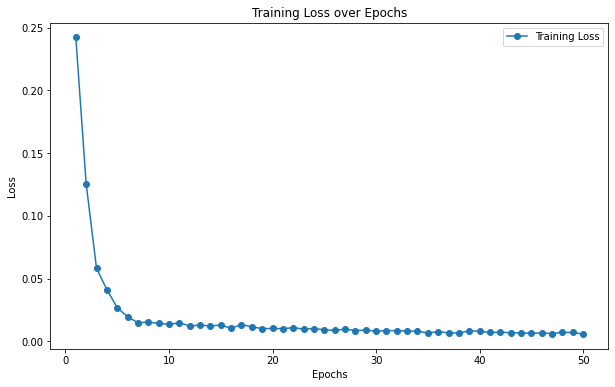

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

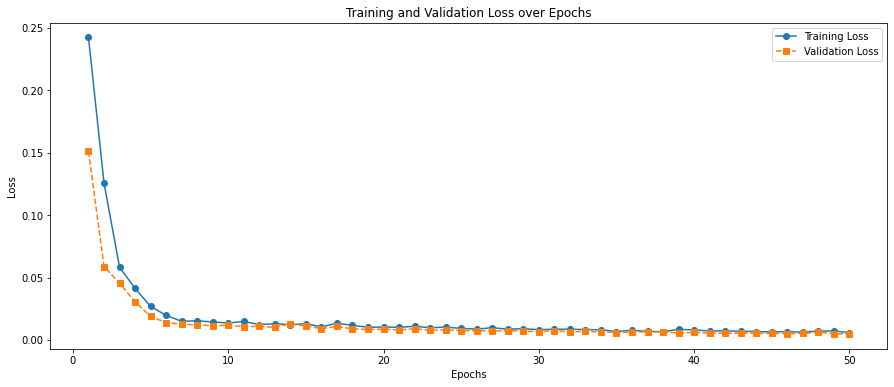

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Indian_model_LT3/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 10ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.062154666558364914
MAE : 0.053614184905156334


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,2.543322e+06,2347500.604
1,3.141495e+06,3151724.833
2,3.498014e+06,3719188.531
3,3.465086e+06,3636501.241
4,2.923754e+06,2526913.818
5,1.599906e+06,1128752.378
6,3.883813e+05,522831.371
7,8.722427e+04,346601.304
8,1.983867e+05,444914.605
9,5.105928e+05,827036.916


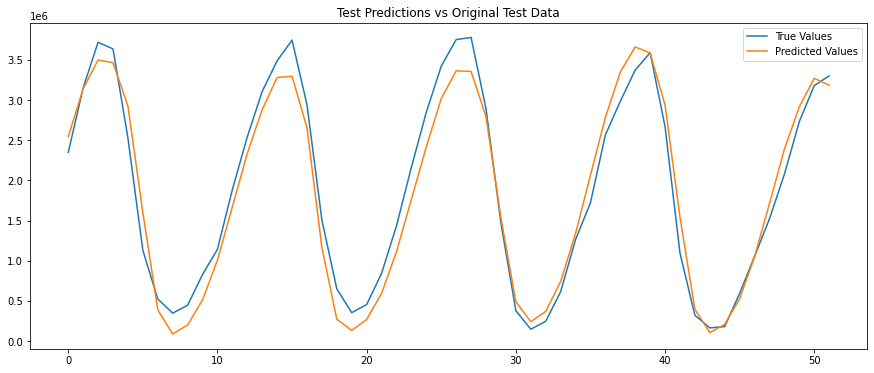

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 11ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

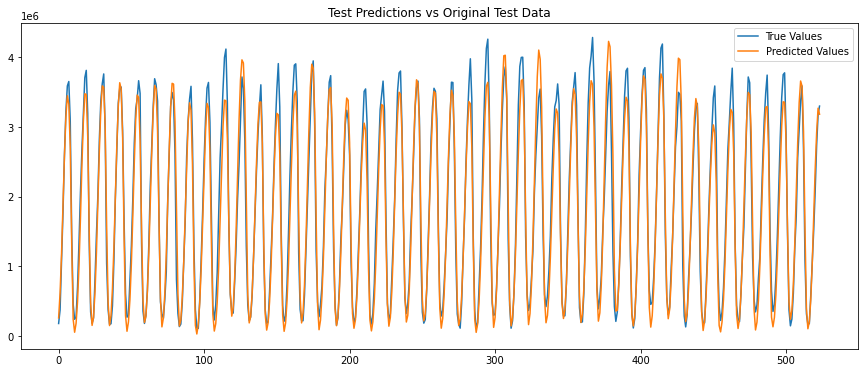

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()